## Approach

* This is a simplied version of YOLO. We take our 512x512 input, divide it into a 4x4 grid, each cell outputs five values:
    * The confidence that there is pneumonia present
    * The x, y, w, and h of the bounding box
    * We have removed the entire classification section, using the confidence to indicate whether there is an ROI in the cell instead.
* A sigmoid is applied to the output of the network to result in values between 0 and 1    
* The x and y coordinates are offsets from the upper left corner of each cell, the w and h are percentage of the total width.
* The loss function is based on YOLO with some differences:
    * The weights of the components have been updated
    * The "objectness" loss of YOLO tries to make the confidence match the actual IOU. Since our model only outputs one box per cell, this effectively drives the confidence down towards the IOU rather than driving the IOU up.
    * We replaced this component of the loss by calculating the IOU for cells with ground truth, subtracting that from 1 and using that as the loss. Since we want to maximize the IOU, why not just do it directly?

## Network

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* The network outputs a 4x4x5 array as described above.
* We are using an Adam optimizer with gradient clipping to avoid exploding gradients.

## Predictions
* To generate our predictions we loop through each cell of the output
* We unnormalize the output to get the actual values
* If the confidence is greater than 0.5 and the box has width and height we append it to the list of candidates.
* We apply non-max suppression to remove duplicates.
* The remaining boxes are concatenated onto the output string.

**Change Log:**
* v3 - changing output to 8x8 grid from 16x16; changed model to downsample one more time; adjusted network accordingly. 
* v4 - changed output to 4x4 grid, no image has more than 3 ROIs so this may work better? 
    * Using center point of ROI to predict instead of upper left corner.
* v5 - We only calculate MSE loss for boxes with a confidence over 0.5 or actual truth since we don't care about predictions for boxes that are not ROIs. This will prevent the network from being constrained by outputting 0s for boxes that don't exist.
* v6 - centering input data so maybe bboxes can be output more accurately? Also centering the image
* v6.2 - labels have ROI centered in center of cell by default instead of mean location.
* v8 - using custom loss function based on YOLO loss. Set default height and width to 1 px because 0 sent the gradients to -inf which screwed everything up.

In [1]:
import os
import csv
import random
import pydicom
import numpy as np
import pickle
import pandas as pd
from skimage import measure
from skimage.transform import resize
import datetime
import math

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [2]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    w = boxes[:,2]
    h = boxes[:,3]
 
    x2 = x1 + w
    y2 = y1 + h

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (w + 1) * (h + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

# get actual x and y values from sigmoid output and what cell they are in
def unnorm(val, idx, cell_size=256):
    x = (val * cell_size) + (cell_size * idx
    return x

# sigmoid in numpy, with limit to avoid nans                             
def sigmoid(x):
    # to avoid NaNs set a lower floor on x values
    y = np.maximum(x, -700)
    return 1 / (1 + np.exp(-y))                             

In [3]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [5]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [6]:
with open('yolo_labels_centered_4x4_6.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

# Load filenames

In [7]:
random.seed(72)

# load and shuffle filenames
folder = './stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = int(len(filenames) * 0.1)
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 23116
n valid samples 2568


 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [14]:
BATCH_SIZE = 16
IMAGE_SIZE = 512
CHECKPOINT_PATH = "yolo8_2_512.h5"

In [15]:
# means to center data
mu_x = 391.456158
mu_y = 363.1358768
mu_w = 220.8453815
mu_h = 334.1743641
mu_center_x = 501.8788487
mu_center_y = 530.2230589

In [16]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # get filename without extension
        filename = filename.split('.')[0]
        label = pneumonia_locations[filename].copy()
        
        # remove the confidence and bboxes because they will be flipped separately
        confs = label[:,:,0]
        boxes = label[:,:,1:]
        
        ## data augmentation may be complicated, let's do that later
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            # flip the image
            img = np.fliplr(img)
            
            # update our x coords
            mask = confs != 0
            
            # flip
            boxes[mask, 0] = 1 - boxes[mask,0]
            
            # flip our boxes lr on axis 0
            boxes = np.flip(boxes, axis=0)         
            
            # flip the confidences lr as well
            confs = np.flip(confs, axis=0)
            
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        
        # center the image
        img = img - 0.5
        
        boxes = np.concatenate([confs.reshape((4,4,1)), boxes], axis=2)
        
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img, boxes
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            
            # unzip images and masks
            imgs, bboxes = zip(*items)
            
            # create numpy batch
            imgs = np.array(imgs)
            bboxes = np.array(bboxes)
            
            labels = bboxes
            return imgs, labels
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [17]:
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)

counter = 0
for imgs, labels in train_gen:
    for label in labels:
        for i in range(4):
            for j in range(4):
                if label[i,j,0] == 1:
                    if label[i,j,4] ==  0.001:
                        print("Error!")
    counter += 1
    if counter > 15:
        break

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


# Network

In [18]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0.1)(x)
    x_1 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_1)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_1])
    return x

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input - 512x512x3
    inputs = keras.Input(shape=(input_size, input_size, 1))
    
    # 256x256x24
    x = keras.layers.Conv2D(channels, 3, strides=(2,2), padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    # 256x256x24 for residual connection
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        
        x = create_downsample(channels, x)
            
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    # dilated convolutions for context - 16x16x512
    x_2 = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_2)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_2")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    x = keras.layers.Conv2D(512, (3,3), padding='same', activation=None, name="last_conv")(x)
    x = keras.layers.add([x, x_2])
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
    # downsample to 4x4x512 with stride 4
    x = keras.layers.Conv2D(512, (4,4), padding='same', strides=(4,4), activation=None, name="downsample_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.1)(x)
    
#     # confidence branch
#     c = keras.layers.Conv2D(384, (1,1), padding='same', activation=None, name="fc_1_c", kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
#     c = keras.layers.BatchNormalization(momentum=0.9)(c)
#     c = keras.layers.LeakyReLU(0.1)(c)
#     c = keras.layers.Dropout(0.25)(c)
    
#     c = keras.layers.Conv2D(256, (1,1), padding='same', activation=None, name="fc_2_c", kernel_regularizer=keras.regularizers.l2(l=0.01))(c)
#     c = keras.layers.BatchNormalization(momentum=0.9)(c)
#     c = keras.layers.LeakyReLU(0.1)(c)
#     c = keras.layers.Dropout(0.10)(c)
    
#     confidence = keras.layers.Conv2D(1, (1,1), padding='same', activation=None, name="confidence_output")(c)
    
    # bounding box branch
    b = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_1_b", kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.15)(b)
    
    b = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_2_b", kernel_regularizer=keras.regularizers.l2(l=0.001))(b)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
#     b = keras.layers.Dropout(0.05)(b)
    
    boxes = keras.layers.Conv2D(5, (1,1), padding='same', activation="linear")(b)
#     boxes = keras.layers.concatenate([confidence, boxes], name="bboxes_output")
    
    # return both outputs
    model = keras.Model(inputs=inputs, outputs=boxes)
    
    return model

# Train network


In [59]:
def binary_accuracy(y_true, y_pred):
    y_pred = tf.sigmoid(y_pred)
    y_true = tf.round(tf.reshape(y_true, [-1, 5]))
    y_pred = tf.round(tf.reshape(y_pred, [-1, 5]))
    
    acc = tf.reduce_mean(tf.cast(tf.equal(y_true[:,0], y_pred[:,0]), dtype=tf.float32))
    return acc
    
def overlap_iou(y_true, y_pred):
    """
    Args:
        bboxes1: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    y_pred = tf.sigmoid(y_pred)
    
    # flatten the data because it's easier that way
    bboxes1 = tf.reshape(y_true, (-1, 5))
    bboxes2 = tf.reshape(y_pred, (-1, 5))
    
    # split the components out
    true_boxes, x11, y11, w1, h1 = tf.split(bboxes1, 5, axis=1)
    pred_conf, x21, y21, w2, h2 = tf.split(bboxes2, 5, axis=1)
    
    # uncenter the data - make sure the numbers are positive
    x11 = x11 * 256
    x21 = x21 * 256
    y11 = y11 * 256
    y21 = y21 * 256
    
    w1 = w1 * 1024
    w2 = w2 * 1024
    h1 = h1 * 1024
    h2 = h2 * 1024
    
    # is there either a box predicted here or a box actually here?
    mask = (pred_conf >= 0.5) | (true_boxes == 1)
    
    # these labels are center points of the boxes so we need to calculate the corners
    x12 = x11 + (w1 / 2)
    y12 = y11 + (h1 / 2)
    x22 = x21 + (w2 / 2)
    y22 = y21 + (h2 / 2)
    
    x11 = x11 - (w1 / 2)
    y11 = y11 - (h1 / 2)
    x21 = x21 - (w2 / 2)
    y21 = y21 - (h2 / 2)

    # find the corners of the intersection area
    xI1 = tf.maximum(x11, x21)
    yI1 = tf.maximum(y11, y21)

    xI2 = tf.minimum(x12, x22)
    yI2 = tf.minimum(y12, y22)
    
    # get the intersection area, if the truth has no boxes it is 0
    inter_area = true_boxes * (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    # get the area of each box
    bboxes1_area = (w1 + 1) * (h1 + 1)
    bboxes2_area = (w2 + 1) * (h2 + 1)
    
    # union is area of both boxes - intersection
    union = (bboxes1_area + bboxes2_area) - inter_area + 1
    
    iou = tf.maximum(inter_area/union, 0)
    
    # apply the mask
    iou = tf.boolean_mask(iou, mask)
    
    # reduce the mean so we have mean iou for our inputs
    return tf.reduce_mean(iou)

def loss_fn(y_true, y_pred):
    # get the iou loss
    iou_loss = iou_loss_fn(y_true, y_pred)
    
    # get the xe loss
    xe_loss = binary_cross_entropy(y_true, y_pred)
    
    # get the box loss
    box_loss = adj_mse(y_true, y_pred)
    
    # add the losses and return them
    return (xe_loss + (box_loss * 3.0) + (iou_loss * 2.0))

# only apply mse to layers with high confidence that there is an ROI or if there actually is an ROI
def adj_mse(y_true, y_pred):
    # coefficients
    lam_coord = 5
    lam_noobj = 0.5
    
    y_pred = tf.sigmoid(y_pred)
        
    # flatten the inputs
    y_true = tf.reshape(y_true, (-1, 5))
    y_pred = tf.reshape(y_pred, (-1, 5))

    # separate the confidence from the boxes
    conf_true, x_true, y_true, w_true, h_true = tf.split(y_true, 5, axis=1)
    conf_pred, x_pred, y_pred, w_pred, h_pred = tf.split(y_pred, 5, axis=1)

    # center squared error
    center_se = tf.square(x_true - y_pred) + tf.square(y_true - y_pred)
    size_se =  tf.square(tf.sqrt(w_true) - tf.sqrt(w_pred)) + tf.square(tf.sqrt(h_true) - tf.sqrt(h_pred))
    
    box_se = center_se + size_se
    
    # only get loss for boxes which are actually positive
    mask = tf.cast(tf.equal(conf_true, 1), tf.float32) * 5.0
    
    box_se = tf.multiply(box_se, mask)
    
    loss = tf.reduce_sum(box_se)
    
    return loss
    
# use weight of 0.5 for negative cells, 19 for positive ones
def binary_cross_entropy(y_true, y_pred):
    conf_true = y_true[...,0]
    conf_pred = tf.sigmoid(y_pred[...,0])
    
    weight = 10.0
    weights = tf.multiply(y_true[...,0], weight) + 0.5
    
    xe = tf.multiply(tf.square(conf_true - conf_pred), weights)
    
    return tf.reduce_sum(xe)

def iou_loss_fn(y_true, y_pred):
    # apply sigmoid to predictions
    y_pred = tf.sigmoid(y_pred)
    
    # separate the x, y from the w, h and unnormalize them
    true_box_xy = y_true[...,1:3] * 256
    true_box_wh = y_true[...,3:] * 1024
    
    pred_box_xy = y_pred[...,1:3] * 256
    pred_box_wh = y_pred[...,3:] * 1024
    
    # get the corners of the boxes by subtracting or adding half of h, w
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half  
    
    # get the corners of the intersect area
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    # get the area of the boxes
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    # calculate the IOU
    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas + 1e-16)
    
    # only use the IOU from boxes which actually have ROIs
    mask = tf.equal(y_true[...,0], 1)
    use_iou = tf.boolean_mask(1 - iou_scores, mask)
    
    return tf.reduce_sum(use_iou)
    
# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=24, n_blocks=1, depth=4)

optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-7, clipnorm=1, clipvalue=0.5)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[binary_accuracy, overlap_iou, adj_mse, binary_cross_entropy])

# cosine learning rate annealing
def exp_decay(x):
    lr0 = 0.001
    epochs_drop = 10
    drop = 0.75
    lrate = lr0 * math.pow(drop, math.floor((1+x)/epochs_drop))
    return lrate

learning_rate = tf.keras.callbacks.LearningRateScheduler(exp_decay)
checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

# create train and validation generators
folder = './stage_1_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_127 (Conv2D)             (None, 256, 256, 24) 216         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_181 (BatchN (None, 256, 256, 24) 96          conv2d_127[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_181 (LeakyReLU)     (None, 256, 256, 24) 0           batch_normalization_181[0][0]    
__________________________________________________________________________________________________
conv2d_128

In [60]:
model.load_weights(CHECKPOINT_PATH)

In [23]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=10, shuffle=True, verbose=1, initial_epoch=4)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 1/10
1443/1444 [============================>.] - ETA: 1s - loss: 72.4050 - binary_accuracy: 0.7590 - overlap_iou: 0.0062 - iou_loss_fn: 4.0383 - adj_mse: 7.1959 - binary_cross_entropy: 38.0617
Epoch 00001: saving model to yolo8_2_512.h5
1444/1444 [==============================] - 1845s 1s/step - loss: 72.3736 - binary_accuracy: 0.7590 - overlap_iou: 0.0062 - iou_loss_fn: 4.0360 - adj_mse: 7.1914 - binary_cross_entropy: 38.0480 - val_loss: 77.3715 - val_binary_accuracy: 0.6793 - val_overlap_iou: 0.0064 - val_iou_loss_fn: 3.6891 - val_adj_mse: 5.7390 - val_binary_cross_entropy: 47.7412
Epoch 2/10
1443/1444 [============================>.] - ETA: 0s - loss: 78.6246 - binary_accuracy: 0.9710 - overlap_iou: 0.0067 - iou_loss_fn: 3.9020 - adj_mse: 6.1921 - binary_cross_entropy: 47.3640
Epoch 00002: saving model to yolo8_2_512.h5
1444/1444 [==============================] - 1129s 782ms/step - loss: 78.6479 - binary_accuracy: 0.9710 - overlap_iou: 0.0067 - iou_loss_fn: 3.9035 - adj_mse

In [47]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=15, shuffle=True, verbose=1, initial_epoch=12)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 13/15
1443/1444 [============================>.] - ETA: 0s - loss: 45.6077 - binary_accuracy: 0.8986 - overlap_iou: 0.0077 - adj_mse: 5.3982 - binary_cross_entropy: 21.5839
Epoch 00013: saving model to yolo8_2_512.h5
1444/1444 [==============================] - 1149s 795ms/step - loss: 45.5996 - binary_accuracy: 0.8986 - overlap_iou: 0.0077 - adj_mse: 5.3971 - binary_cross_entropy: 21.5810 - val_loss: 39.6829 - val_binary_accuracy: 0.8900 - val_overlap_iou: 0.0080 - val_adj_mse: 4.9542 - val_binary_cross_entropy: 17.6346
Epoch 14/15
1443/1444 [============================>.] - ETA: 0s - loss: 43.9270 - binary_accuracy: 0.9016 - overlap_iou: 0.0083 - adj_mse: 5.0246 - binary_cross_entropy: 21.2085
Epoch 00014: saving model to yolo8_2_512.h5
1444/1444 [==============================] - 1124s 778ms/step - loss: 43.9120 - binary_accuracy: 0.9016 - overlap_iou: 0.0083 - adj_mse: 5.0225 - binary_cross_entropy: 21.2027 - val_loss: 36.8945 - val_binary_accuracy: 0.9214 - val_overlap_iou:

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=25, shuffle=True, verbose=1, initial_epoch=19)

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 20/25
1443/1444 [============================>.] - ETA: 0s - loss: 35.0507 - binary_accuracy: 0.9269 - overlap_iou: 0.0959 - adj_mse: 3.9756 - binary_cross_entropy: 16.4449
Epoch 00020: saving model to yolo8_2_512.h5
1444/1444 [==============================] - 1153s 798ms/step - loss: 35.0354 - binary_accuracy: 0.9269 - overlap_iou: 0.0959 - adj_mse: 3.9736 - binary_cross_entropy: 16.4387 - val_loss: 30.2516 - val_binary_accuracy: 0.9226 - val_overlap_iou: 0.0967 - val_adj_mse: 3.4672 - val_binary_cross_entropy: 13.8660
Epoch 21/25
1443/1444 [============================>.] - ETA: 0s - loss: 34.1699 - binary_accuracy: 0.9295 - overlap_iou: 0.1007 - adj_mse: 3.8614 - binary_cross_entropy: 16.0335
Epoch 00021: saving model to yolo8_2_512.h5
1444/1444 [==============================] - 1122s 777ms/step - loss: 34.1654 - binary_accuracy: 0.9295 - overlap_iou: 0.1007 - adj_mse: 3.8602 - binary_cross_entropy: 16.0333 - val_loss: 29.5301 - val_binary_accuracy: 0.9390 - val_overlap_iou:

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=35, shuffle=True, verbose=1, initial_epoch=25)

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


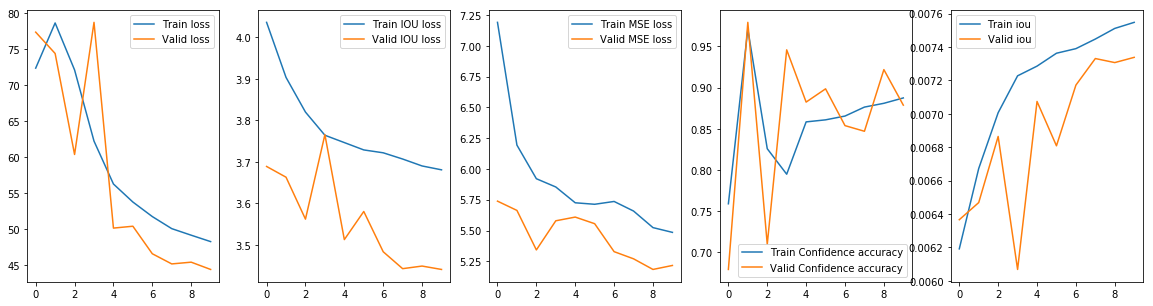

In [24]:
plt.figure(figsize=(20,5))
plt.subplot(151)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(152)
plt.plot(history.epoch, history.history["iou_loss_fn"], label="Train IOU loss")
plt.plot(history.epoch, history.history["val_iou_loss_fn"], label="Valid IOU loss")
plt.legend()
plt.subplot(153)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(154)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(155)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

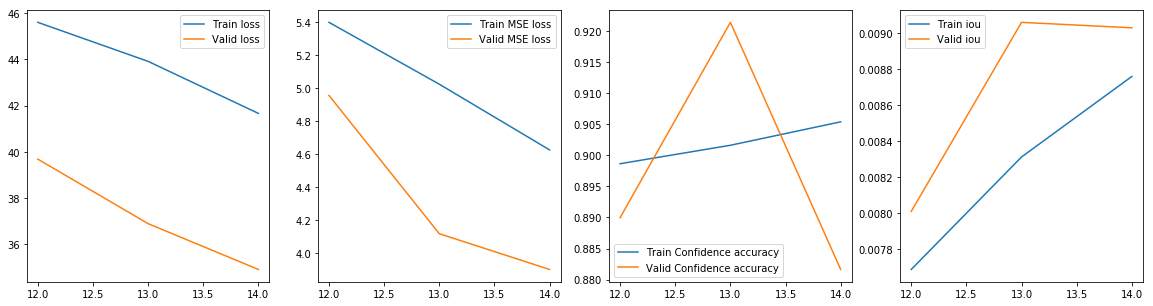

In [49]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(142)
plt.plot(history.epoch, history.history["adj_mse"], label="Train MSE loss")
plt.plot(history.epoch, history.history["val_adj_mse"], label="Valid MSE loss")
plt.legend()
plt.subplot(143)
plt.plot(history.epoch, history.history["binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(144)
plt.plot(history.epoch, history.history["overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

## Sample Predictions

In [ ]:
THRESHOLD = 0.5
OVERLAP = 0.3
# look at some sample predictions
samples = np.random.choice(valid_filenames, size=10, replace=False)

coords = np.arange(0, 1024, 256)

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    
    filename = filename.split('.')[0]
    
    f, ax = plt.subplots(figsize=(6, 6))
    plt.imshow(img)
    
    # draw the truth
    ious = []
    if filename in pneumonia_locations:
        locs = pneumonia_locations[filename]
        for i in range(4):
            for j in range(4):
                pixel_data = locs[i,j,:]
                if pixel_data[0] > 0.5:
                    x, y, w, h = pixel_data[1:]
                    
                    # unnormalize the data
                    w = w * 1024
                    h = h * 1024
                    
                    x = unnorm(x, j, 256)
                    y = unnorm(y, i, 256)
                    
                    # get the corners
                    x = x - (w // 2)
                    y = y - (h // 2)
                    
                    x = int(x)
                    y = int(y)
                    w = int(w)
                    h = int(h)
                    
                    print("Truth:", i, j, x, y, w, h)
                    
                    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    ax.add_patch(rect)
                    
    # predict the image
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    yhat = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    yhat = sigmoid(yhat)
    conf = np.squeeze(yhat)[:,:,0]
    bboxes = np.squeeze(yhat)[:,:,1:]
    boxes = []
    pred_boxes = np.zeros_like(bboxes)
    
    # loop through our predictions
    for i in range(4):
        for j in range(4):
            conf_ = conf[i,j]
            # if we have a prediction
            if conf_ > THRESHOLD:
                x,y,w,h = bboxes[i,j,:]
                print("Pred:", i, j, "conf:", conf_)
                
                # unnormalize the data
                w = w * 1024
                h = h * 1024

                x = unnorm(x, j, 256)
                y = unnorm(y, i, 256)
                
                # convert to upper left corner from center
                x = np.maximum(x - (w // 2), 0)
                y = np.maximum(y - (h // 2), 0)
                
                x = int(x)
                y = int(y)
                w = int(w)
                h = int(h)
                
                pred_boxes[i,j,:] = [x, y, w, h]
                
                # if the boxes have width and height add them to our list
                if w > 30 and h > 30:
                    boxes.append([x,y,w,h])
                
                # if the pred corresponds to truth calculate the IOU
                if locs[i,j, 0] == 1:
                    x1_p, y1_p, w_p, h_p = w, y, w, h
                    x1_t, y1_t, w_t, h_t = locs[i, j, 1:]
                    
                    # unnormalize the truth
                    w_t, h_t = w_t * 1024, h_t * 1024
                    x1_t = unnorm(x1_t, j, 256)
                    y1_t = unnorm(y1_t, i, 256)
                    
                    x2_p, y2_p = x1_p + w_p, y1_p + h_p
                    x2_t, y2_t = x1_t + w_t, y1_t + h_t

                    # unfudge the true width and height
                    if w_t == 0.001:
                        w_t = 0
                    if h_t == 0.001:
                        gh_t = 0
                    
                    # get corners of intersection
                    x1_i = np.maximum(x1_p, x1_t)
                    y1_i = np.maximum(y1_p, y1_t)
                    x2_i = np.minimum(x2_p, x2_t)
                    y2_i = np.minimum(y2_p, y2_t)

                    # get area of intersect
                    i_w, i_h = np.abs(x2_i - x1_i), np.abs(y2_i - y1_i)
                    
                    # if there 
                    intersect_area = i_w * i_h
                    
                    if intersect_area < 0:
                        print("i_w:", i_w, "i_h:", i_h, "x1:", x1_i, "x2:", x2_i, "y1:", y1_i, "y2:", y2_i)
                    
                    # get union area
                    true_area = w_t * h_t
                    pred_area = w_p * h_p
                    union_area = true_area + pred_area - intersect_area

                    iou_score = intersect_area / (union_area + 1e-6)
                    print("intersect:", intersect_area, "true:", true_area, "pred:", pred_area, "union:", union_area, "iou:", iou_score)
                    ious.append(iou_score)

                # if there is no truth the IOU is 0
                else:
                    ious.append(0)
                
    # do non-max suppression of our boxes
    boxes = non_max_suppression_fast(np.array(boxes), OVERLAP)
    
    # plot our boxes
    for box in boxes:
        x,y,w,h = box
        print(x, y, w, h)
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    for item in coords:
        plt.axvline(item, linewidth=0.5)
        plt.axhline(item, linewidth=0.5)
    
    print("Mean IOU:", np.mean(ious))
    plt.show()

# Predict test images

In [ ]:
THRESHOLD = 0.5

# load and shuffle filenames
folder = './stage_1_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=3, image_size=IMAGE_SIZE, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    
    # predict batch of images
    conf_preds, bbox_preds = model.predict(imgs)
    
    # loop through batch
    for confs, bboxes, filename in zip(conf_preds, bbox_preds, filenames):
        predictionString = ""
        print(filename)
        boxes = []
        for i in range(4):
            for j in range(4):
                conf = confs[i, j, 0]
                if conf > THRESHOLD:
                    x, y, w, h = bboxes[i,j]
                    
                    # possible thresholds to keep our boxes within reasonable sizes?
                    if True: #w < 600 and h < 1000:
                        w = w * 1024
                        h = h * 1024

                        x = unnorm(x, j, 256)
                        y = unnorm(y, i, 256)

                        # convert to upper left corner from center
                        x = x - (w // 2)
                        y = y - (h // 2)
                        
                        if w > 20 and h > 20:
                            # make sure our boxes don't run off the edges of the images
                            w = np.minimum(w, 1024 - x)
                            h = np.minimum(h, 1024 - y)
                            boxes.append([x,y,w,h])

        # do our non-max suppression here
        boxes = non_max_suppression_fast(np.array(boxes), 0.3)
        
        # loop through our suppressed boxes and creat the prediction string
        for box in boxes:
            x,y,w,h = box
            
            x = int(x)
            y = int(y)
            w = int(w)
            h = int(h)
        
            # create the prediction string
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + ' '
            
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString

    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
    break
    
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']

now = datetime.datetime.now()
today = str(now)[:10]
submission_file = today + "_yolo_submission.csv" 
sub.to_csv(submission_file)

In [ ]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f submission.csv -m "YOLOv8 512x512 25 epochs"

In [ ]:
save_file_to_drive("submission.csv", "submission.csv")
save_file_to_drive(CHECKPOINT_PATH, CHECKPOINT_PATH)

In [ ]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp ./{CHECKPOINT_PATH} gs://{bucket_name}/